<a href="https://colab.research.google.com/github/johhan27/DS-Unit-2-Applied-Modeling/blob/master/DS_Sprint_Challenge_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [96]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox
    !pip install matplotlib

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [97]:
# YOUR CODE HERE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [98]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url)
# YOUR CODE HERE

df["Inspection Date"] = pd.to_datetime(df["Inspection Date"])
df = df.set_index('Inspection Date')

In [99]:
df.isna().sum()

Inspection ID                  0
DBA Name                       0
AKA Name                     623
License #                      5
Facility Type                224
Risk                          12
Address                        0
City                          53
State                         10
Zip                           26
Inspection Type                1
Violations                  9655
Latitude                     198
Longitude                    198
Location                     198
Fail                           0
Serious Violations Found    9655
dtype: int64

**Task 1 Test**

In [100]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [101]:
'''T2. Identify data leakage column.'''
leaky_col = 'Serious Violations Found'
# YOUR CODE HERE


**Task 2 Test**

In [102]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [103]:
df.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail,Serious Violations Found
count,5.191600e+04,5.191100e+04,51890.000000,51718.000000,51718.000000,51916.000000,42261.000000
mean,1.330265e+06,1.549491e+06,60628.834669,41.879568,-87.676663,0.258610,0.279217
std,6.202664e+05,9.018283e+05,22.736963,0.081126,0.059509,0.437875,0.679656
min,4.425000e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000,0.000000
25%,6.796205e+05,1.140745e+06,60614.000000,41.830296,-87.707857,0.000000,0.000000
50%,1.424226e+06,1.958619e+06,60625.000000,41.890166,-87.666524,0.000000,0.000000
75%,1.946952e+06,2.215507e+06,60643.000000,41.939167,-87.634461,1.000000,0.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000,8.000000


In [104]:
df.describe(exclude='number')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Type,Violations,Location
count,51916,51293,51692,51904,51916,51863,51906,51915,42261,51718
unique,17049,16350,329,3,13954,39,1,51,42164,13410
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,Canvass,45. FOOD HANDLER REQUIREMENTS MET - Comments: ...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,654,802,34264,37731,741,51659,51906,24170,3,741


In [105]:
'''T3. Write wrangle function.'''
def wrangle(df):
  
  #leaky col
  df.drop('Serious Violations Found', inplace=True, axis=1)

  #high card cols
  high_card_cols = [col for col in df.describe(exclude='number').columns.to_list() if df[col].nunique() > 500]
  df.drop(high_card_cols, axis=1, inplace=True)

  #single category col 
  df.drop('State', inplace=True, axis=1)

  #unimportant num cols
  bad_num_cols = ['Inspection ID', 'License #']
  df.drop(bad_num_cols, axis=1, inplace=True)

  #problematic cols
  #df.drop(["Facility Type", "City"], axis=1, inplace=True)

  
  return df
# YOUR CODE HERE
#raise NotImplementedError()
df = wrangle(df)

**Task 3 Test**

In [106]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [107]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
features = df.columns.to_list()
features.remove(target)
# YOUR CODE HERE
#raise NotImplementedError()

X = df[features]
y = df[target]


**Task 4 Test**

In [108]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [109]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE
X_train, y_train = X[X.index.year < 2017], y[y.index.year < 2017]
X_val, y_val = X[X.index.year > 2016], y[y.index.year > 2016]

**Task 5 Testing**

In [110]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [111]:
y_train.value_counts(normalize=True)

0    0.750663
1    0.249337
Name: Fail, dtype: float64

In [112]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
#raise NotImplementedError()
from sklearn.metrics import accuracy_score

y_train_mode = y_train.mode()

baseline_acc = accuracy_score(y_train, [y_train_mode for times in range(len(y_train))])


print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [113]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [114]:
X_train.isna().sum()

Facility Type      215
Risk                12
City                41
Zip                 26
Inspection Type      1
Latitude           162
Longitude          162
dtype: int64

In [143]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE
#raise NotImplementedError()
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
#from sklearn.preprocessing import OrdinalEncoder
from category_encoders.ordinal import OrdinalEncoder


model_bag = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier()
)

model_bag.fit(X_train, y_train);

**Tast 7 Testing**

In [116]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [144]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
#raise NotImplementedError()
import xgboost as xgb

model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    xgb.XGBClassifier()
)

model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [141]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [145]:
print ("model_bag train", accuracy_score(y_train, model_bag.predict(X_train)))
print ("model_bag valid", accuracy_score(y_val, model_bag.predict(X_val)))
print(" ")
print("model_boost train", accuracy_score(y_train, model_boost.predict(X_train)))
print ("model_boost valid", accuracy_score(y_val, model_boost.predict(X_val)))
print ("Didn't beat the baseline and boosting seems to perform better")

model_bag train 0.907858560260119
model_bag valid 0.6790563980572901
 
model_boost train 0.7552059674373013
model_boost valid 0.704133214391912
Didn't beat the baseline and boosting seems to perform better


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

In [120]:
model_bag.predict_proba(X_val)[:,1]

array([0.86386905, 0.10179513, 0.01369048, ..., 0.26886264, 0.34407068,
       0.        ])

In [121]:
'''T9. Plot ROC-curve.'''
# YOUR CODE HERE
#raise NotImplementedError()

from sklearn.metrics import roc_curve

y_pred_proba_bag = model_bag.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_bag)

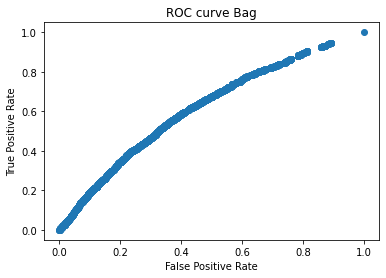

In [122]:
plt.scatter(fpr, tpr)
plt.title('ROC curve Bag')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [123]:
from sklearn.metrics import roc_auc_score
print ("roc_auc_score Bag" , roc_auc_score(y_val, y_pred_proba_bag))

roc_auc_score Bag 0.618526497921121


In [124]:
y_pred_proba_boost = model_boost.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_boost)

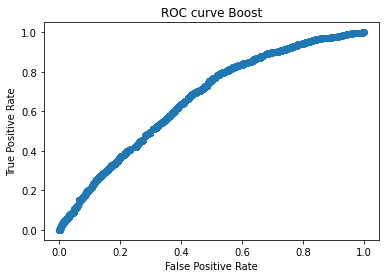

In [125]:
plt.scatter(fpr, tpr)
plt.title('ROC curve Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [126]:
print ("roc_auc_score Boost" , roc_auc_score(y_val, y_pred_proba_boost))

roc_auc_score Boost 0.6627437505187082


**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [127]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
# YOUR CODE HERE
#raise NotImplementedError()
model_cr = classification_report(y_val, model_boost.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.71      0.99      0.83      7092
           1       0.55      0.02      0.04      2997

    accuracy                           0.70     10089
   macro avg       0.63      0.51      0.43     10089
weighted avg       0.66      0.70      0.59     10089



**Task 10 Testing**

In [128]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [146]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE
#raise NotImplementedError()
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

transformer = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent')
)

X_train_transformed = transformer.fit_transform(X_train)
#X_train_transformed.columns = X_train.columns
X_val_transformed = transformer.transform(X_val)
#X_val_transformed.columns = X_val.columns 

model = xgb.XGBClassifier()
model.fit(X_train_transformed, y_train)


perm = PermutationImportance(
    model,
    scoring= 'accuracy',
    random_state=1).fit(X_val_transformed, y_val)

eli5.show_weights(perm, feature_names = X_val.columns.tolist())


Weight,Feature
0.0024 ± 0.0008,Inspection Type
0.0015 ± 0.0017,Latitude
0.0012 ± 0.0007,Zip
0.0009 ± 0.0011,Facility Type
0.0008 ± 0.0015,Longitude
0.0006 ± 0.0007,Risk
-0.0002 ± 0.0001,City


In [147]:
permutation_importances = pd.DataFrame({"Feature Importance":perm.feature_importances_, "Feature Importance STD": perm.feature_importances_std_}, index=X_val.columns.to_list() )

In [148]:
permutation_importances

,Feature Importance,Feature Importance STD
Facility Type,0.000912,0.000559
Risk,0.000634,0.000347
City,-0.000178,0.000040
Zip,0.001249,0.000374
Inspection Type,0.002379,0.000381
Latitude,0.001546,0.000861
Longitude,0.000773,0.000761


**Task 11 Testing**

In [149]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7efda28bb1d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7efdabd495d0>})

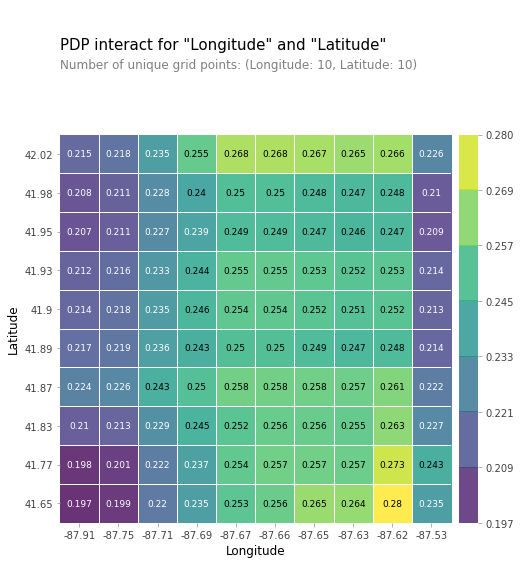

In [155]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''

# YOUR CODE HERE
from pdpbox.pdp import pdp_interact, pdp_interact_plot,pdp_isolate, pdp_plot

features = ['Longitude', 'Latitude']
X_val = X_val.dropna()

model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    xgb.XGBClassifier()
)

model.fit(X_train, y_train);

#X_val_transformed.columns = X_val.columns

interaction = pdp_interact(
    model = model, 
    dataset= X_val, 
    model_features=X_val.columns, 
    features = features
)


pdp_interact_plot(interaction, plot_type='grid',feature_names = features)

What do you think? Is there a relationship between location and failing a food saftey inspection?

YES, looking at the heatmap we can see that certain locations are more or less likely to fail the inspection 

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7efda2c91490>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7efda2f2cc90>})

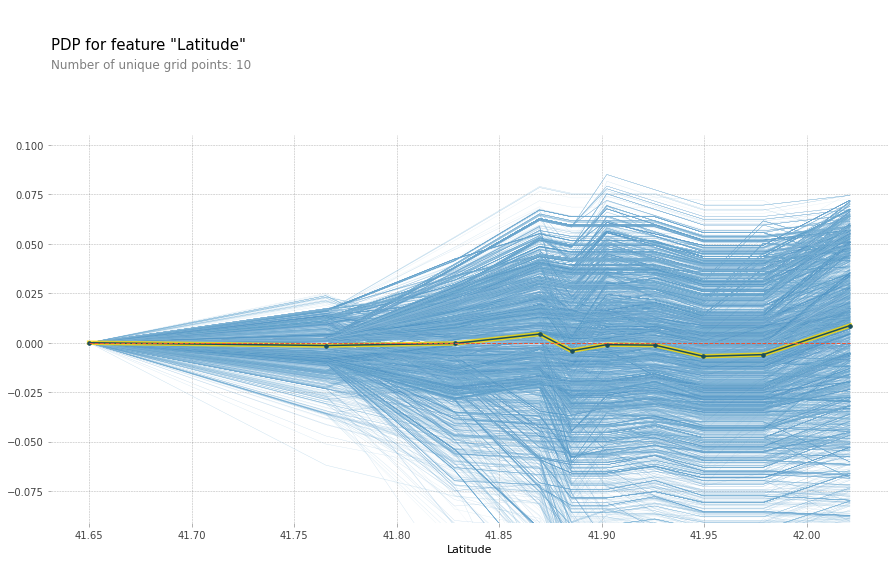

In [157]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Latitude'

#X_val_transformed.columns = X_val.columns

isolated = pdp_isolate(
    model = model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature = feature
)


pdp_plot(isolated,feature_name = feature, plot_lines=True)